# Diagnostica delle catene markoviane {#sec-diagnostics_mcmc}

**Prerequisiti**

**Concetti e competenze chiave**

**Preparazione del Notebook**

In [23]:
%run ../../config.py # Import the configuration settings
import itertools
import logging
import statistics as stat
from scipy import stats
import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

## Introduzione {.unnumbered}

Le catene di Markov sono utilizzate per approssimare la distribuzione a posteriori. Tuttavia, è fondamentale riconoscere che tale approssimazione è soggetta a errori e imperfezioni. @de2020tutorial propongono una *When-to-Worry- and-How-to-Avoid-the-Misuse-of-Bayesian-Statistics* (WAMBS) checklist. 

La diagnostica delle catene Markoviane, quindi, si configura come un insieme di pratiche e strumenti mirati a indagare vari aspetti della convergenza. Questi includono l'accuratezza dell'approssimazione della distribuzione a posteriori, l'efficienza del campionamento e l'esplorazione esaustiva dello spazio dei parametri. Tali strumenti diagnostici possono essere sia grafici che numerici e dovrebbero essere applicati in un contesto olistico per fornire una panoramica completa della qualità della catena di Markov. 

Non esiste un'unica metrica o diagnostico che possa fornire un quadro completo; piuttosto, è l'analisi combinata di più metriche e diagnostici che permette di acquisire una comprensione più profonda del comportamento della catena. Inoltre, l'esperienza del ricercatore gioca un ruolo significativo nel distinguere tra una "buona" e una "cattiva" catena di Markov e nel suggerire strategie per migliorare la qualità del campionamento.

In sintesi, l'analisi della convergenza e la diagnostica delle catene Markoviane sono fasi imprescindibili nel processo di inferenza bayesiana, soprattutto quando si utilizzano metodi MCMC. La loro applicazione consente di garantire che le stime a posteriori siano tanto accurate e affidabili quanto possibile.

## Grafici di Tracciamento

Un metodo diagnostico comunemente utilizzato per valutare la convergenza nei metodi di Monte Carlo basati su catene di Markov (MCMC) è l'analisi dei grafici di tracciamento, o "trace plots". Questi grafici rappresentano sequenzialmente le stime dei parametri posteriori ottenute ad ogni iterazione della catena. In generale, si tende a interpretare che un parametro sta convergendo quando le stime campionarie si aggregano in una banda orizzontale ristretta lungo l'asse delle iterazioni che compongono la catena. Tuttavia, considerare questa disposizione come prova conclusiva di convergenza è piuttosto grossolano, in quanto una traccia compatta non garantisce che la convergenza sia stata effettivamente raggiunta. Di fatto, questa metodologia risulta essere più un indicatore di non-convergenza. Ad esempio, se due catene per lo stesso parametro sono campionate da regioni diverse della distribuzione target e le stime rimangono separate lungo la storia della catena, ciò costituisce un'evidenza di non-convergenza. Allo stesso modo, se il grafico mostra fluttuazioni significative o salti nella catena, è probabile che la catena associata a quel parametro non abbia raggiunto la convergenza.

Un trace plot ideale presenta una dispersione casuale dei valori attorno a un livello medio stabile, indicando una buona miscelazione delle catene e un'adeguata configurazione del processo MCMC. Questo pattern suggerisce che l'algoritmo è assestato su una distribuzione stabile e le inferenze tratte dai dati campionati sono affidabili.

Approfondendo con l'esempio di @martin2022bayesian, è possibile osservare diversi esempi di trace plots per catene MCMC. Questi esempi illustrano sia scenari in cui il comportamento è ottimale, segnalando una convergenza adeguata, sia casi in cui le catene mostrano segni di problemi di convergenza o di miscelazione. Tali situazioni indicano la necessità di un'ulteriore affinazione dei parametri dell'algoritmo MCMC per garantire l'affidabilità delle stime statistiche ottenute.

In [24]:
good_chains = stats.beta.rvs(2, 5, size=(2, 2000))
bad_chains0 = np.random.normal(
    np.sort(good_chains, axis=None), 0.05, size=4000
).reshape(2, -1)

bad_chains1 = good_chains.copy()
for i in np.random.randint(1900, size=4):
    bad_chains1[i % 2 :, i : i + 100] = np.random.beta(i, 950, size=100)

chains = {
    "good_chains": good_chains,
    "bad_chains0": bad_chains0,
    "bad_chains1": bad_chains1,
}

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_95156/2425599176.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


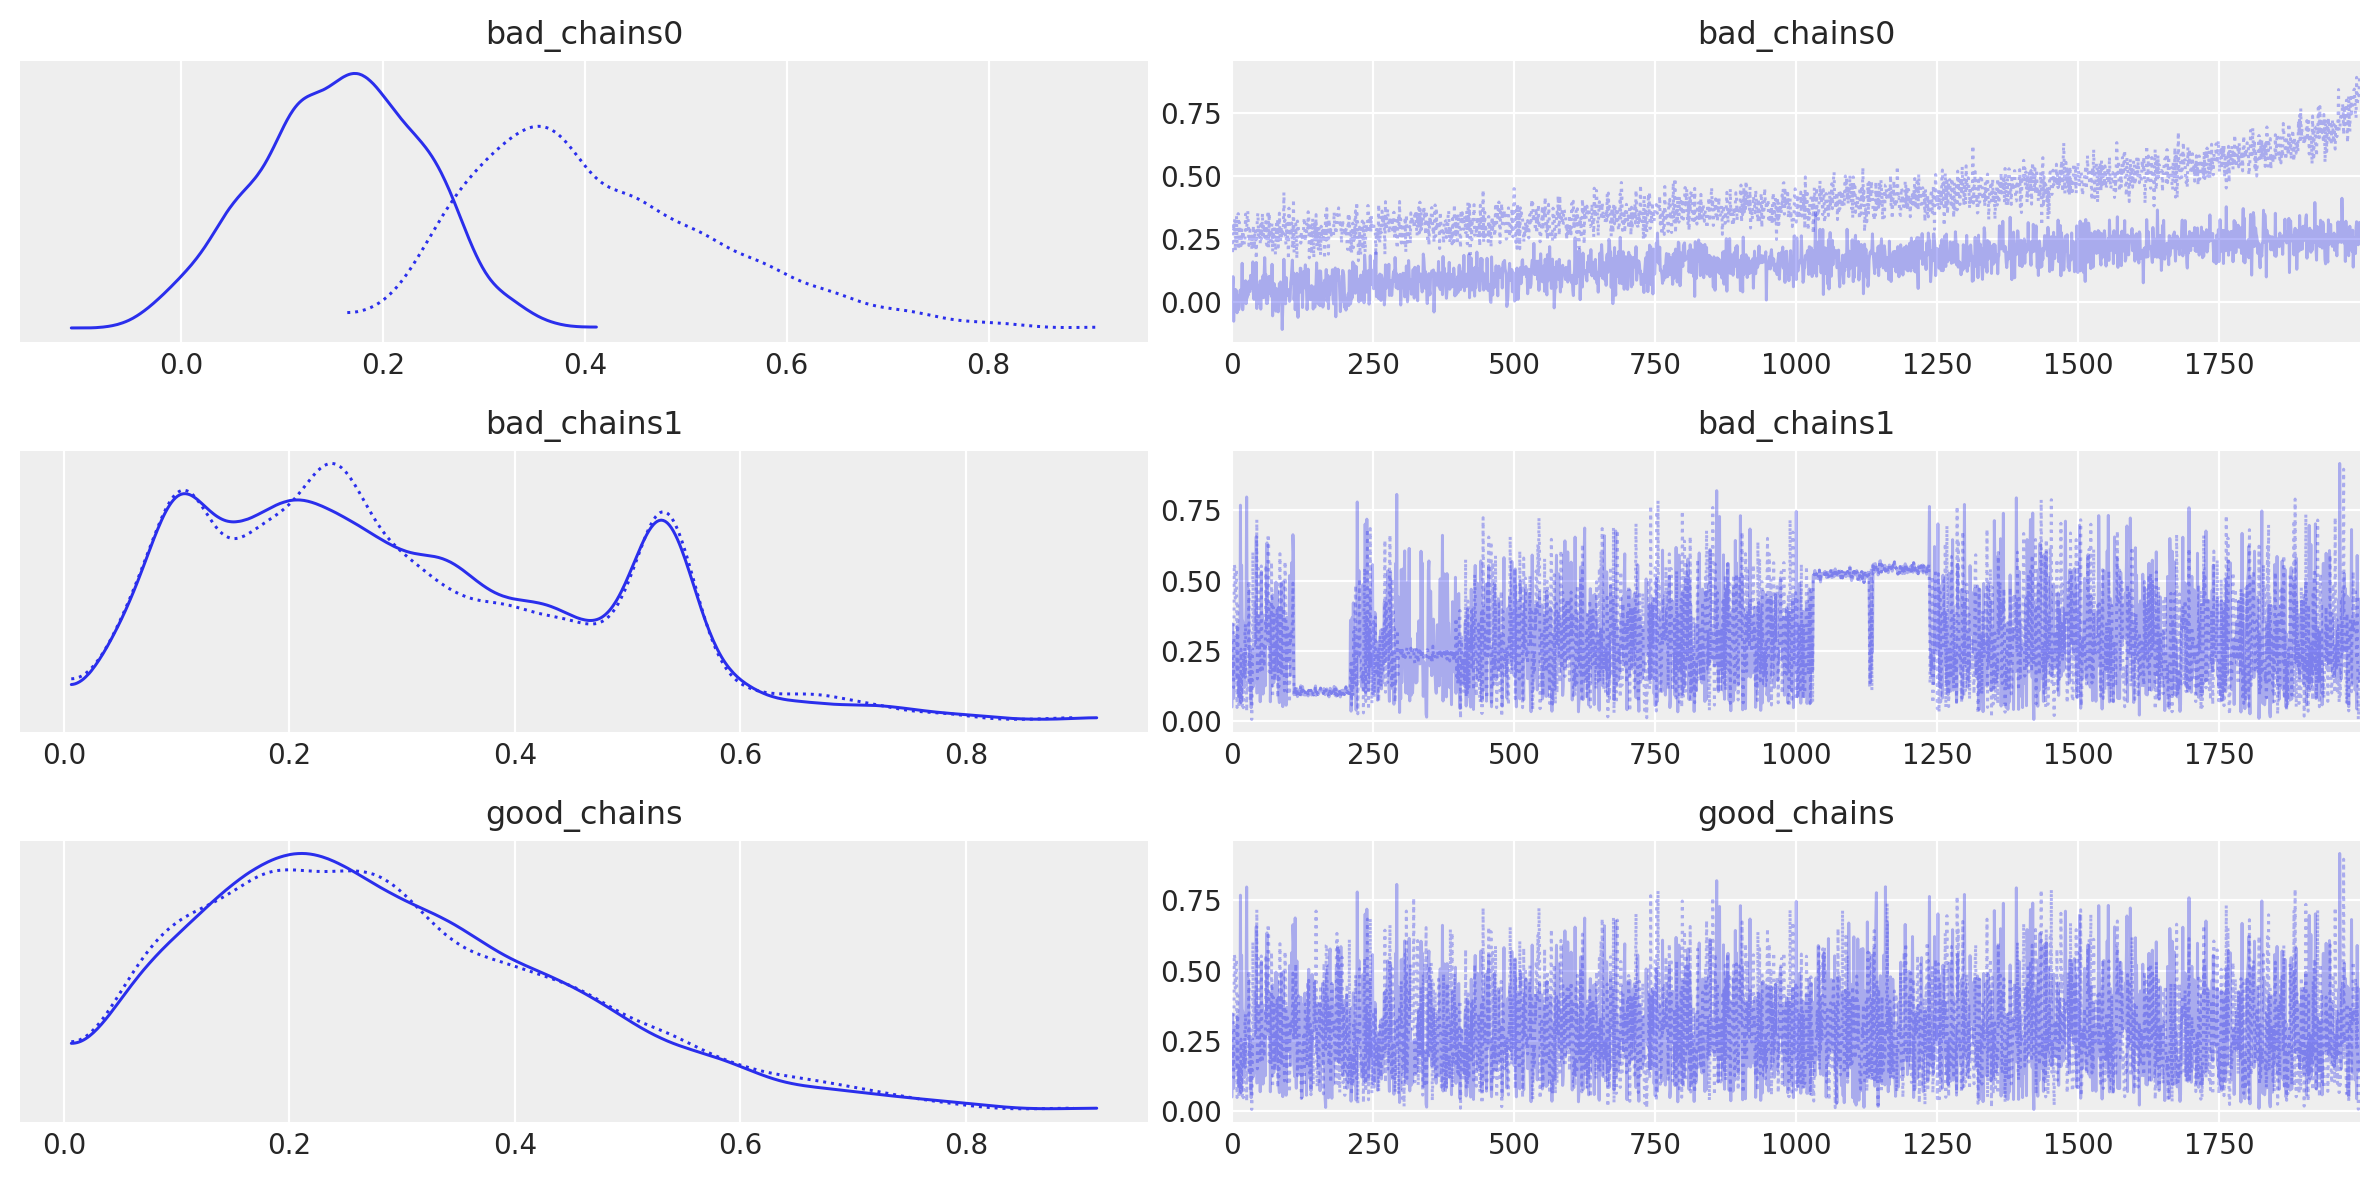

In [25]:
az.plot_trace(chains)
plt.tight_layout()

Le cattive catene non convergono né si mescolano tra loro. Uno dei motivi per l'esecuzione di più catene è che ogni singola catena potrebbe convergere verso un target, mentre un'altra catena potrebbe convergere su un target diverso, e questo sarebbe un problema. Inoltre, catene altrimenti sane possono bloccarsi occasionalmente nel corso della serie, il che suggerirebbe la necessità di modifiche al modello o alle impostazioni del campionatore. Un altro modo per valutare la convergenza dell'algoritmo è plottando la densità della distribuzione a posteriori degli effetti stimati, per assicurarsi che si avvicini ad una classica curva a campana. 

In pratica, non abbiamo mai il privilegio di poter confrontare i risultati del campionamento MCMC con la corretta distribuzione a posteriori. Ecco perché la diagnostica delle catene di Markov è così importante: se vediamo trace-plots come le precedenti "bad chains", sappiamo che non abbiamo ottenuto una approssimazione adeguata della distribuzione a posteriori. In tali circostanze possiamo ricorrere ad alcuni rimedi.

1.  Controllare il modello. Siamo sicuri che le distribuzioni a priori e la verosimiglianza siano appropriate per i dati osservati?
2.  Utilizzare un numero maggiore di iterazioni. Alcune tendenze indesiderate a breve termine della catena possono appianarsi nel lungo termine.

## I Grafici della Densità Posteriore Sono Adeguati?

I grafici della densità posteriore rappresentano uno degli strumenti diagnostici più efficaci per identificare eventuali anomalie nella convergenza delle catene di Markov nell'analisi bayesiana. Questi grafici mostrano la distribuzione dei valori campionati per ogni parametro del modello statistico e per ogni catena di Markov. L'importanza di questi grafici è primaria: essi sono la base da cui deriviamo le statistiche riassuntive dei parametri del modello, quali la media, la mediana, o l'intervallo di credibilità.

Prendiamo come esempio un parametro di interesse in un modello di regressione che assume una distribuzione a priori gaussiana (normale). In un contesto ideale, senza problemi di convergenza, ci aspetteremmo che la densità posteriore del parametro sia anch'essa normalmente distribuita, centrata intorno a una media con una certa varianza. Questo andamento simmetrico e unimodale della densità posteriore è un segnale che la catena di Markov ha esplorato adeguatamente lo spazio dei parametri e che i campioni estratti possono essere considerati rappresentativi della distribuzione posteriore effettiva del parametro.

Tuttavia, se il grafico della densità posteriore mostra deviazioni significative dalla forma attesa, come ad esempio asimmetrie marcate o bimodalità, questo suggerisce che potrebbero esserci problemi nella convergenza della catena al vero valore del parametro. Una distribuzione bimodale, in particolare, può indicare che la catena è rimasta "intrappolata" in aree locali dello spazio dei parametri, senza riuscire a esplorare adeguatamente l'intero spazio e raggiungere l'equilibrio.

Per risolvere tali problemi e ottenere una stima più accurata della distribuzione posteriore, potremmo considerare diverse strategie:

1. **Aumentare il Numero di Iterazioni**: Incrementare il numero delle iterazioni delle catene di Markov può permettere una migliore esplorazione dello spazio dei parametri e aiutare a superare le barriere tra i picchi di una distribuzione bimodale.

2. **Ottimizzazione delle Distribuzioni a Priori**: La scelta delle distribuzioni a priori può influenzare fortemente la convergenza della catena. Selezionare priori più informativi o più flessibili può aiutare la catena a guidare l'esplorazione dello spazio dei parametri in modo più efficace.

3. **Affinamento dei Parametri dell'Algoritmo MCMC**: Modificare i parametri di configurazione dell'algoritmo MCMC, come il passo del campionamento o i criteri di accettazione, può migliorare la qualità del campionamento e favorire una convergenza più rapida e stabile.

In definitiva, l'analisi dei grafici della densità posteriore non solo fornisce una stima visiva dell'andamento dei parametri, ma serve anche come fondamento per decisioni metodologiche che possono migliorare la robustezza e l'affidabilità delle inferenze bayesiane.

## L'Autocorrelazione nelle Catene di Markov Monte Carlo È Troppo Alta?

Nell'ambito dell'analisi bayesiana tramite le catene di Markov Monte Carlo (MCMC), è di fondamentale importanza valutare la rapidità con cui i campioni estratti dalla distribuzione a posteriori raggiungono l'indipendenza. Inizialmente, come è noto, i campioni della distribuzione a posteriori non sono indipendenti l'uno dall'altro, ma ci si aspetta che, nel tempo, la catena "dimentichi" il suo stato iniziale e converga verso un insieme di estrazioni indipendenti e stazionarie dalla distribuzione a posteriori.

Una metodologia per determinare la velocità con cui la catena si allontana dallo stato iniziale è l'analisi della funzione di autocorrelazione (ACF), che si basa sull'osservazione che un campione $\theta^{(s)}$ tende a essere più simile al campione immediatamente precedente $\theta^{(s-1)}$ rispetto a quelli più distanti come $\theta^{(s-2)}$, $\theta^{(s-3)}$, e così via. La correlazione di lag-l per una catena stazionaria di Markov, dove $s = 1, \ldots, S$, può essere espressa come:

$$
\rho_l = \text{cor}(\theta^{(s)}, \theta^{(s+l)}).
$$

In generale, ci aspettiamo che l'autocorrelazione a lag-1 sia vicina a 1, ma che diminuisca man mano che il lag aumenta, indicando che i componenti della catena stanno diventando indipendenti. Una riduzione rapida dell'autocorrelazione con il numero di iterazioni è preferibile, poiché una lenta diminuzione può suggerire che la catena sia "intrappolata" e non esplori completamente il supporto della distribuzione target.

Il correlogramma, che mostra l'autocorrelazione in funzione dei ritardi fino a un certo valore (ad esempio 20), è utile per valutare questa caratteristica. Se l'autocorrelazione a lag 1 non è eccessivamente alta e diminuisce rapidamente con l'incremento dei lag, ciò indica che la catena sta fornendo una buona approssimazione di un campionamento casuale dalla distribuzione $p(\theta \mid y)$.

Catene che mostrano un rapido "mixing" si comportano in modo simile a un campione indipendente: i valori si concentrano nei range più plausibili della distribuzione a posteriori e l'autocorrelazione tra i campioni diminuisce rapidamente, risultando in un rapporto campionario effettivo alto. Al contrario, catene che non sono rapidamente "mixing" tendono a non concentrarsi nei valori più plausibili, presentano un'autocorrelazione che diminuisce lentamente e un rapporto campionario effettivo basso.

In caso di catene non rapidamente "mixing", si possono adottare due strategie:

1. **Aumento del Numero di Iterazioni**: Anche una catena lenta nel "mixing" può alla fine fornire una buona approssimazione della distribuzione a posteriori se si permette un numero sufficientemente grande di iterazioni.
2. **Thinning (Diradamento)**: Questo processo consiste nel selezionare solo alcuni campioni a intervalli regolari, come ogni secondo o ogni decimo valore della catena, con l'obiettivo di ridurre le autocorrelazioni presenti nei lag più brevi.

Un esempio pratico è fornito da @martin2022bayesian.

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_95156/4208770402.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


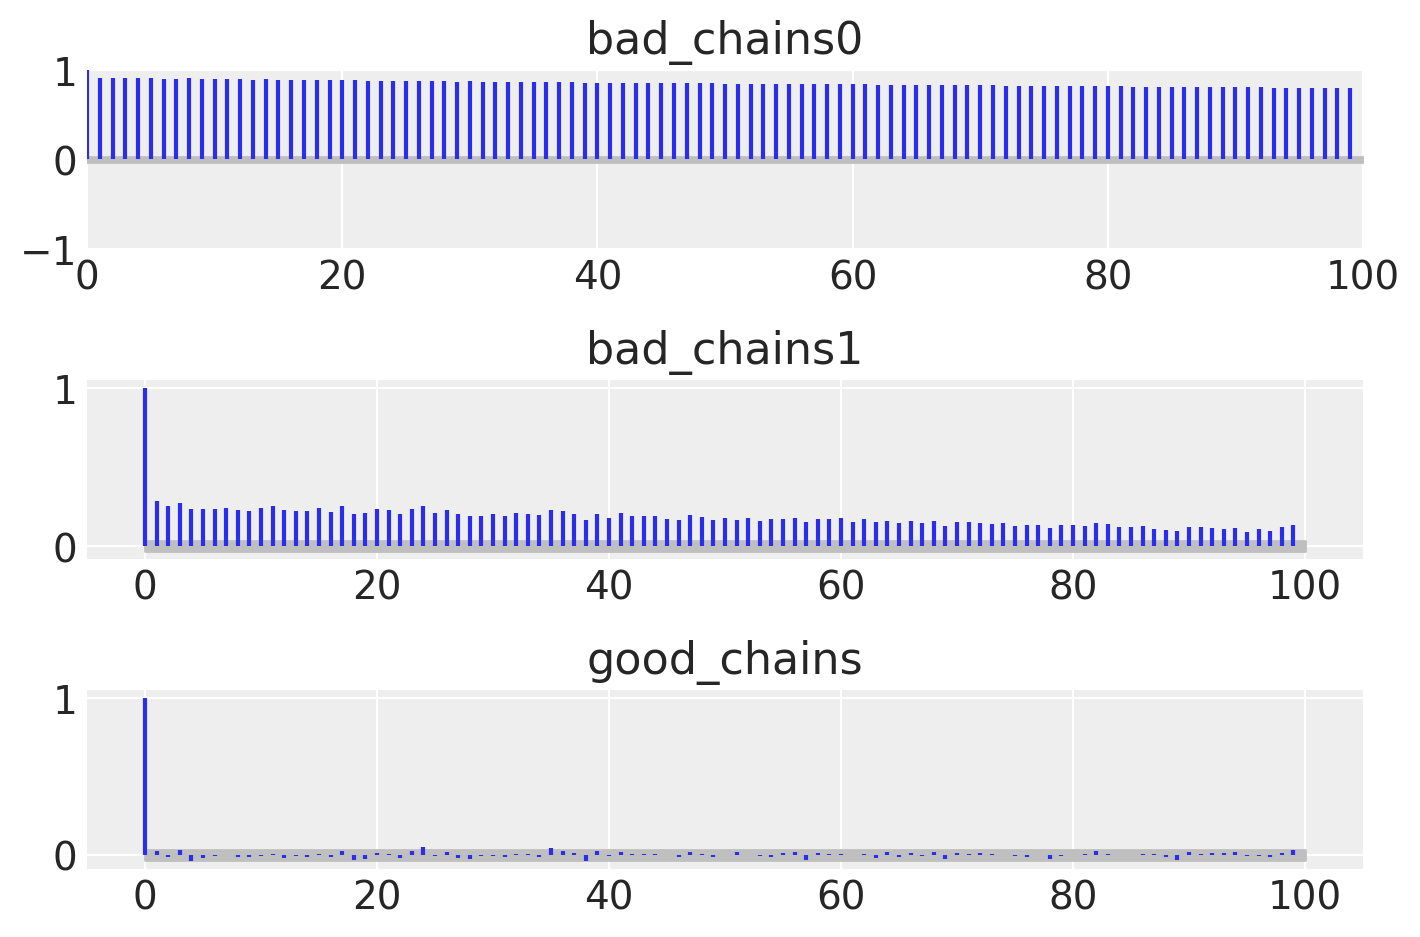

In [26]:
fig, ax = plt.subplots(3, 1)  
az.plot_autocorr(chains, combined=True, ax=ax)
plt.tight_layout()

## La Dimensione Effettiva del Campione È Sufficiente?

Nell'ambito delle analisi con catene di Markov Monte Carlo (MCMC), un aspetto strettamente correlato alla diagnosi di autocorrelazione è la dimensione effettiva del campione, indicata con $N_{\text{eff}}$ nell'output del software Stan. Questa grandezza rappresenta una stima del numero di estrazioni indipendenti dalla distribuzione a posteriori. In altre parole, corrisponde al numero di campioni indipendenti che possiede lo stesso potere di stima di $T$ campioni autocorrelati. Seguendo la notazione di Stan, la $N_{\text{eff}}$ è calcolata come segue:

$$
N_{\text{eff}} = \frac{T}{1 + 2 \sum_{s=1}^{S} \rho_{s}},
$$

dove $T$ è il numero totale di campioni e $\rho_{s}$ rappresenta l'autocorrelazione a lag $s$.

Poiché i campioni della distribuzione a posteriori non sono indipendenti, ci aspettiamo che la $N_{\text{eff}}$ sia minore del numero totale di estrazioni. Se il rapporto tra la dimensione effettiva del campione e il numero totale di estrazioni è vicino a 1, ciò indica che l'algoritmo ha raggiunto un campionamento sostanzialmente indipendente. Valori molto inferiori potrebbero essere motivo di preoccupazione poiché indicano una forte dipendenza tra i campioni, ma è importante notare che questo rapporto dipende fortemente dalla scelta dell'algoritmo MCMC, dal numero di iterazioni di "warmup" (o "burn-in"), e dal numero di iterazioni successive al "warmup".

Un metodo per affrontare il problema dell'autocorrelazione e del conseguente abbassamento della dimensione effettiva del campione coinvolge l'uso del diradamento (*thinning*). Supponiamo che l'algoritmo venga impostato per effettuare 3.000 estrazioni dalla distribuzione a posteriori. Questo può essere paragonato a effettuare 30.000 estrazioni ma conservando solo ogni decima. Sebbene questo metodo sia un modo per ridurre il carico sulla memoria, il vantaggio è che tipicamente l'autocorrelazione viene ridotta, risultando in una dimensione effettiva del campione maggiore.

Per distinguere tra buone e cattive catene MCMC, possiamo utilizzare la statistica $N_{\text{eff}}$. Un basso valore di $N_{\text{eff}}$ può indicare una catena con una mescolanza insufficiente, suggerendo la necessità di aumentare il numero di iterazioni o di implementare il diradamento. In contrasto, un valore alto di $N_{\text{eff}}$ è indice di una catena con una buona mescolanza, che assicura un campionamento efficace dalla distribuzione a posteriori. Esempi pratici di queste considerazioni sono illustrati in @martin2022bayesian, dove la statistica $N_{\text{eff}}$ è utilizzata per valutare la qualità delle catene MCMC.

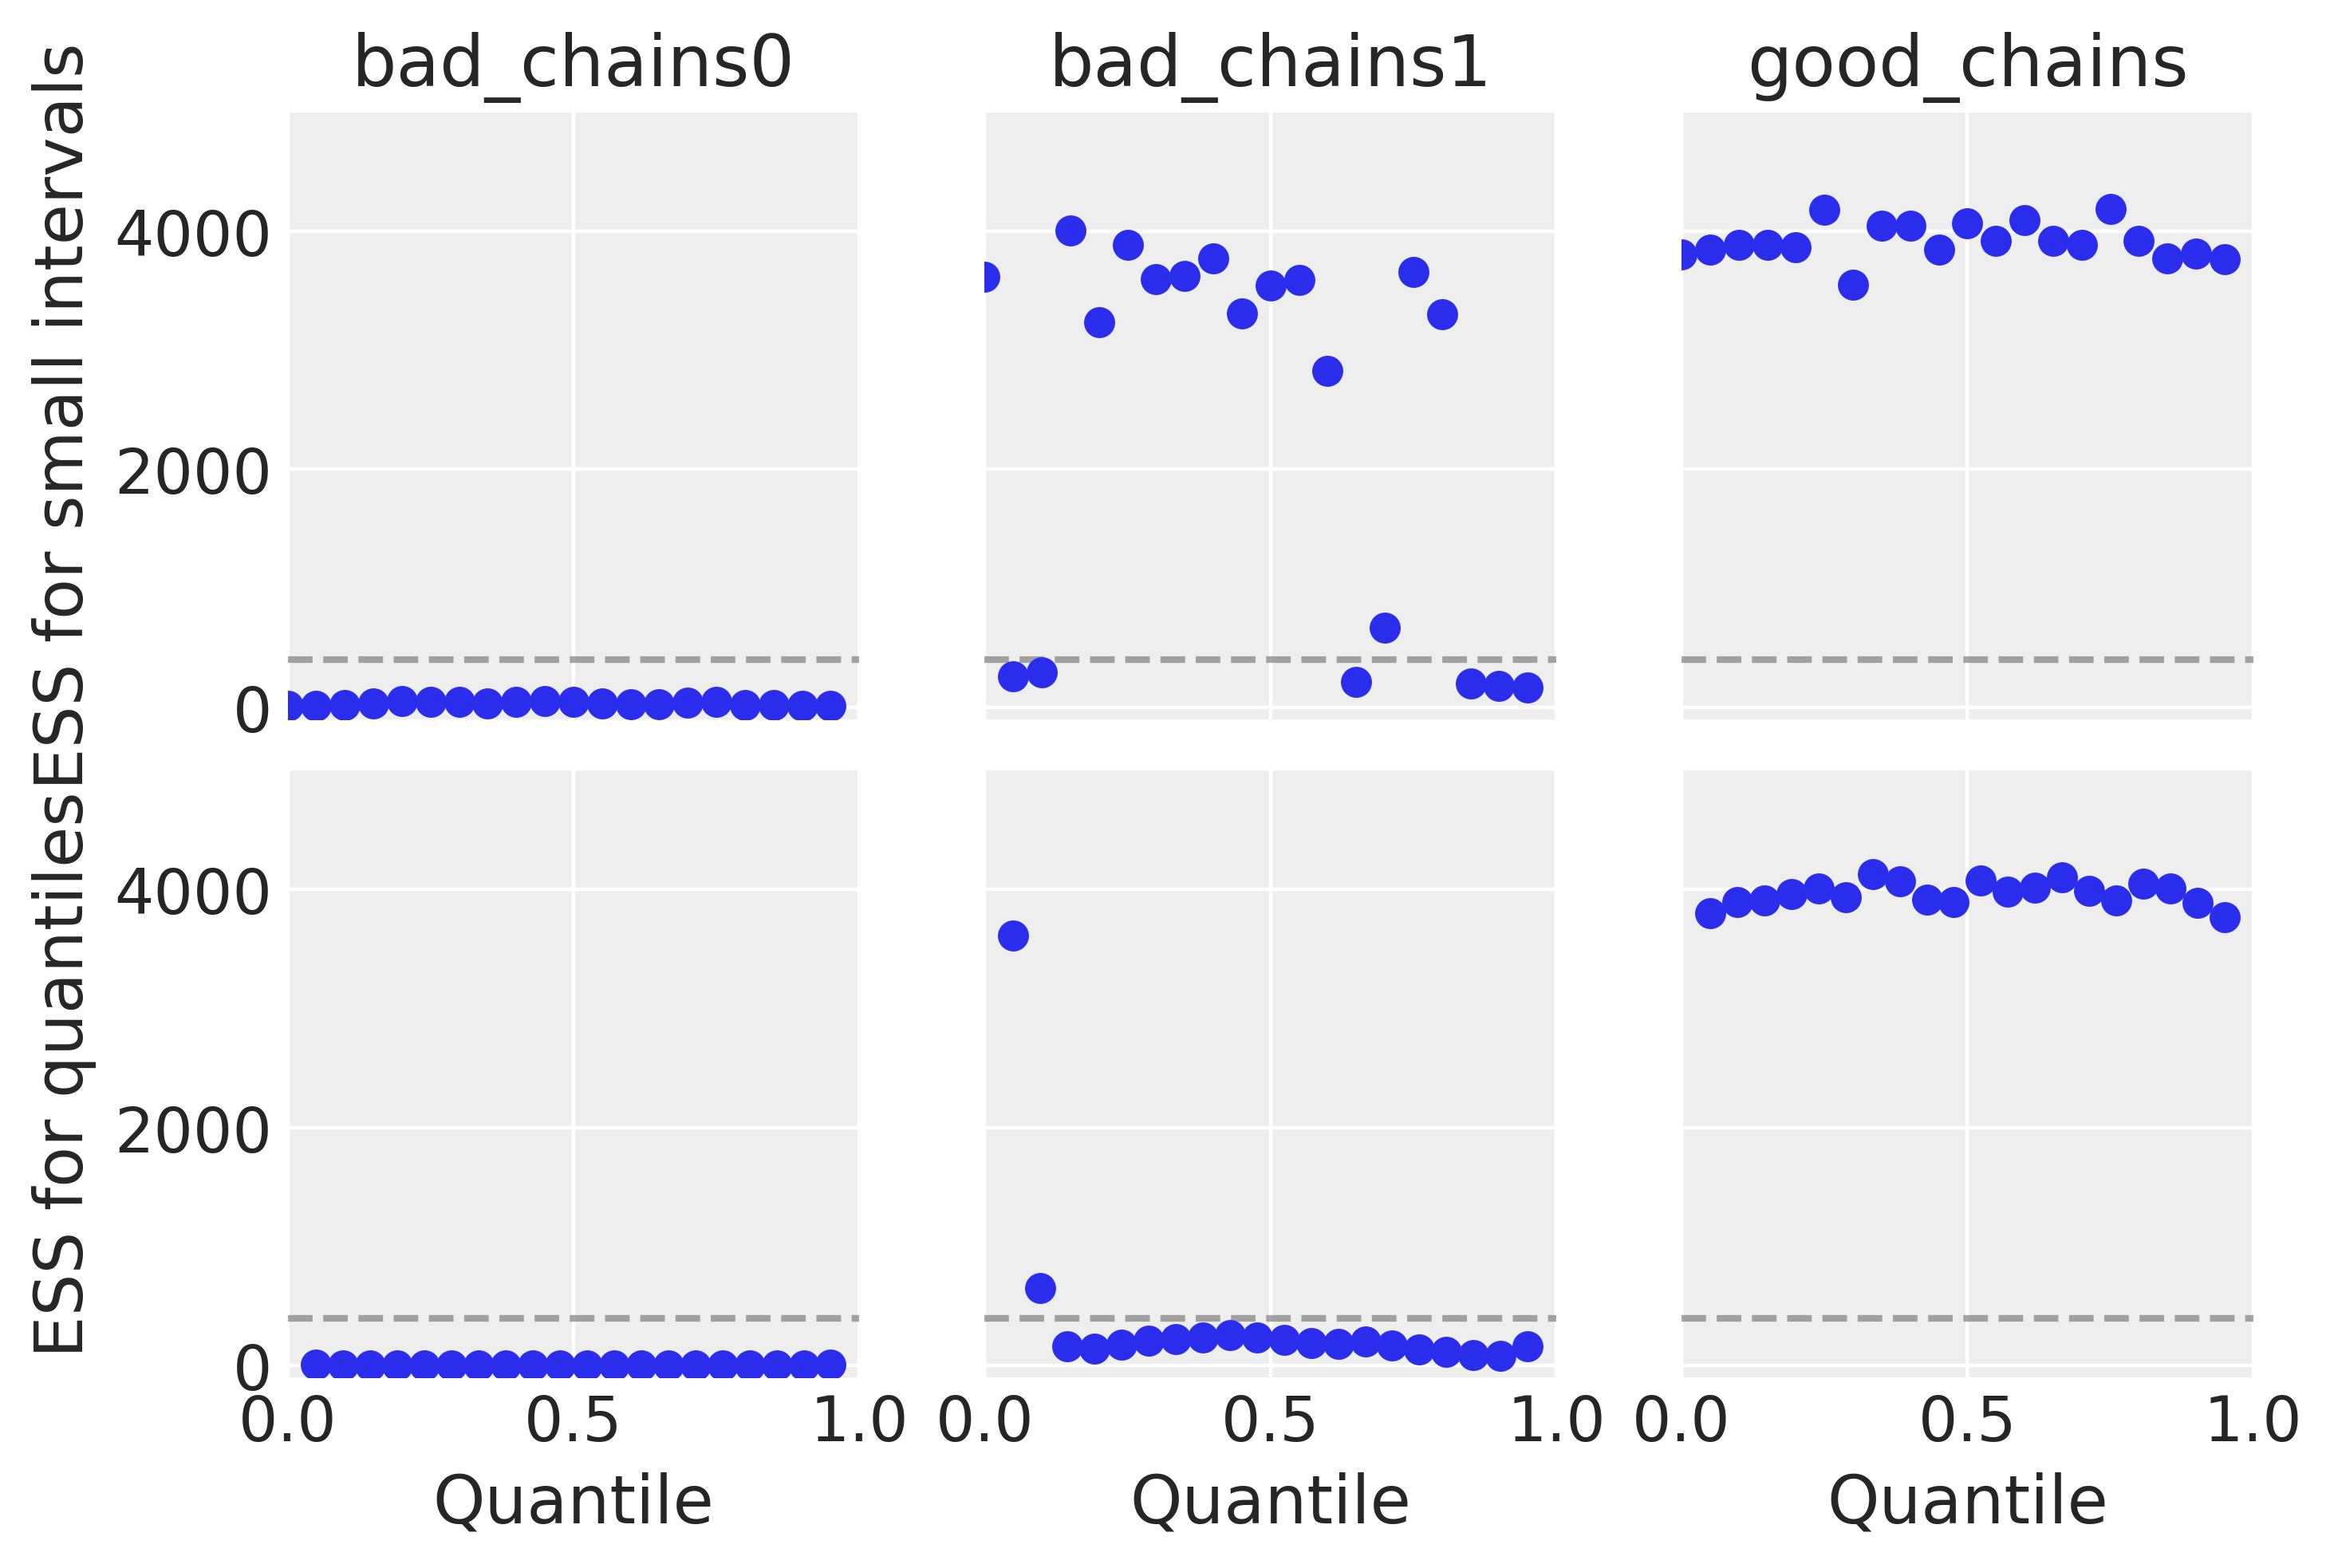

In [21]:
_, axes = plt.subplots(2, 3, sharey=True, sharex=True)
az.plot_ess(chains, kind="local", ax=axes[0])
az.plot_ess(chains, kind="quantile", ax=axes[1])

for ax_ in axes[0]:
    ax_.set_xlabel("")
for ax_ in axes[1]:
    ax_.set_title("")

for ax_ in axes[:, 1:].ravel():
    ax_.set_ylabel("")
plt.ylim(-100, 5000);

## La Statistica $\hat{R}$ È Prossima a Uno?

Nell'ambito dell'analisi bayesiana, è cruciale assicurarsi che ogni catena di Markov sia stazionaria e che le diverse catene mostrino coerenza tra loro. La statistica $\hat{R}$, introdotta da Gelman e Rubin nel 1992, serve proprio a valutare il grado di convergenza tra più catene per ciascun parametro in esame. Questo indicatore si basa sul confronto tra due tipi di varianza: la varianza media all'interno di ogni singola catena (W) e la varianza tra le diverse catene (B). Questo metodo ricorda l'approccio dell'analisi della varianza unidirezionale, in cui si confrontano stime di varianza per determinare se esistono differenze significative, in questo caso tra le catene.

La formula per calcolare $\hat{R}$ è $\hat{R} = \frac{W + \frac{1}{n} (B - W)}{W}$, e tale metrica viene calcolata automaticamente dalla maggior parte dei software Bayesiani, come indicato da Gelman e collaboratori nel 2014. Nel contesto pratico, un valore di $\hat{R}$ superiore a 1.1 è generalmente considerato un segnale di convergenza inadeguata delle catene. Inoltre, è fondamentale esaminare visivamente la convergenza delle catene attraverso il confronto delle distribuzioni posteriori di ciascun parametro per ogni catena. In condizioni ideali, $\hat{R}$ dovrebbe essere pari a 1. Se $\hat{R}$ si discosta notevolmente da questo valore, ciò indica che la convergenza non è stata ancora raggiunta.

Più specificamente, un valore di $\hat{R}$ maggiore di 1.01, secondo @vehtari2021rank, segnala una mancanza di coerenza nelle approssimazioni della distribuzione a posteriori ottenute dalle diverse catene parallele. Un valore così elevato di $\hat{R}$ suggerisce una simulazione non stabile, indicando la necessità di ulteriori iterazioni o di un raffinamento del modello per garantire una convergenza affidabile. Questo aspetto è fondamentale per assicurare che le simulazioni Monte Carlo basate su catene di Markov (MCMC) forniscano risultati consistenti e attendibili per l'analisi statistica in corso.

In [11]:
az.rhat(chains)

<xarray.Dataset> Size: 24B
Dimensions:      ()
Data variables:
    bad_chains0  float64 8B 2.43
    bad_chains1  float64 8B 1.018
    good_chains  float64 8B 1.001

Nell'esempio di @martin2022bayesian vediamo come $\hat{R}$ è in grado di distinguere tra le buone e le cattive catene MCMC. Mentre `bad_chains0` ha valori $\hat{R}$ totalmente inadeguati, `bad_chains1` tende ad avere valori accettabili e `good_chains` ha un valore $\hat{R}$ praticamente uguale a 1.0.

## La Diagnostica di Geweke È Prossima a Zero?

La statistica diagnostica di convergenza di Geweke è basata su un test per l'uguaglianza delle medie della prima e dell'ultima parte di una catena di Markov (di default il primo 10% e l'ultimo 50% della catena). Se i due campioni sono estratti dalla distribuzione stazionaria della catena, le due medie sono statisticamente uguali e la statistica di Geweke ha una distribuzione asintotica Normale standardizzata.

**Interpretazione:** la statistica di Geweke è uguale a zero quando le medie delle due porzioni della catena di Markov sono uguali; valori maggiori di $\mid 2 \mid$ suggeriscono che la catena non ha ancora raggiunto una distribuzione stazionaria.


## L'Errore Standard di Monte Carlo È Piccolo?

Quando utilizziamo i metodi MCMC introduciamo un ulteriore livello di incertezza poiché stiamo approssimando il posteriore con un numero finito di campioni. Possiamo stimare la quantità di questo tipo di errore mediante la statistica *errore standard di Monte Carlo* (MCSE). Il MCSE è definitp come la deviazione standard delle catene MCMC divisa per la loro numerosità campionaria effettiva (ESS). Il MCSE ci fornisce dunque un'indicazione quantitativa di quanto è grande sia il "rumore" della stima.

Per l'esempio di @martin2022bayesian otteniamo i valori seguenti.

In [12]:
az.mcse(chains)

<xarray.Dataset> Size: 24B
Dimensions:      ()
Data variables:
    bad_chains0  float64 8B 0.1087
    bad_chains1  float64 8B 0.01616
    good_chains  float64 8B 0.002583

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_95156/1242931680.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


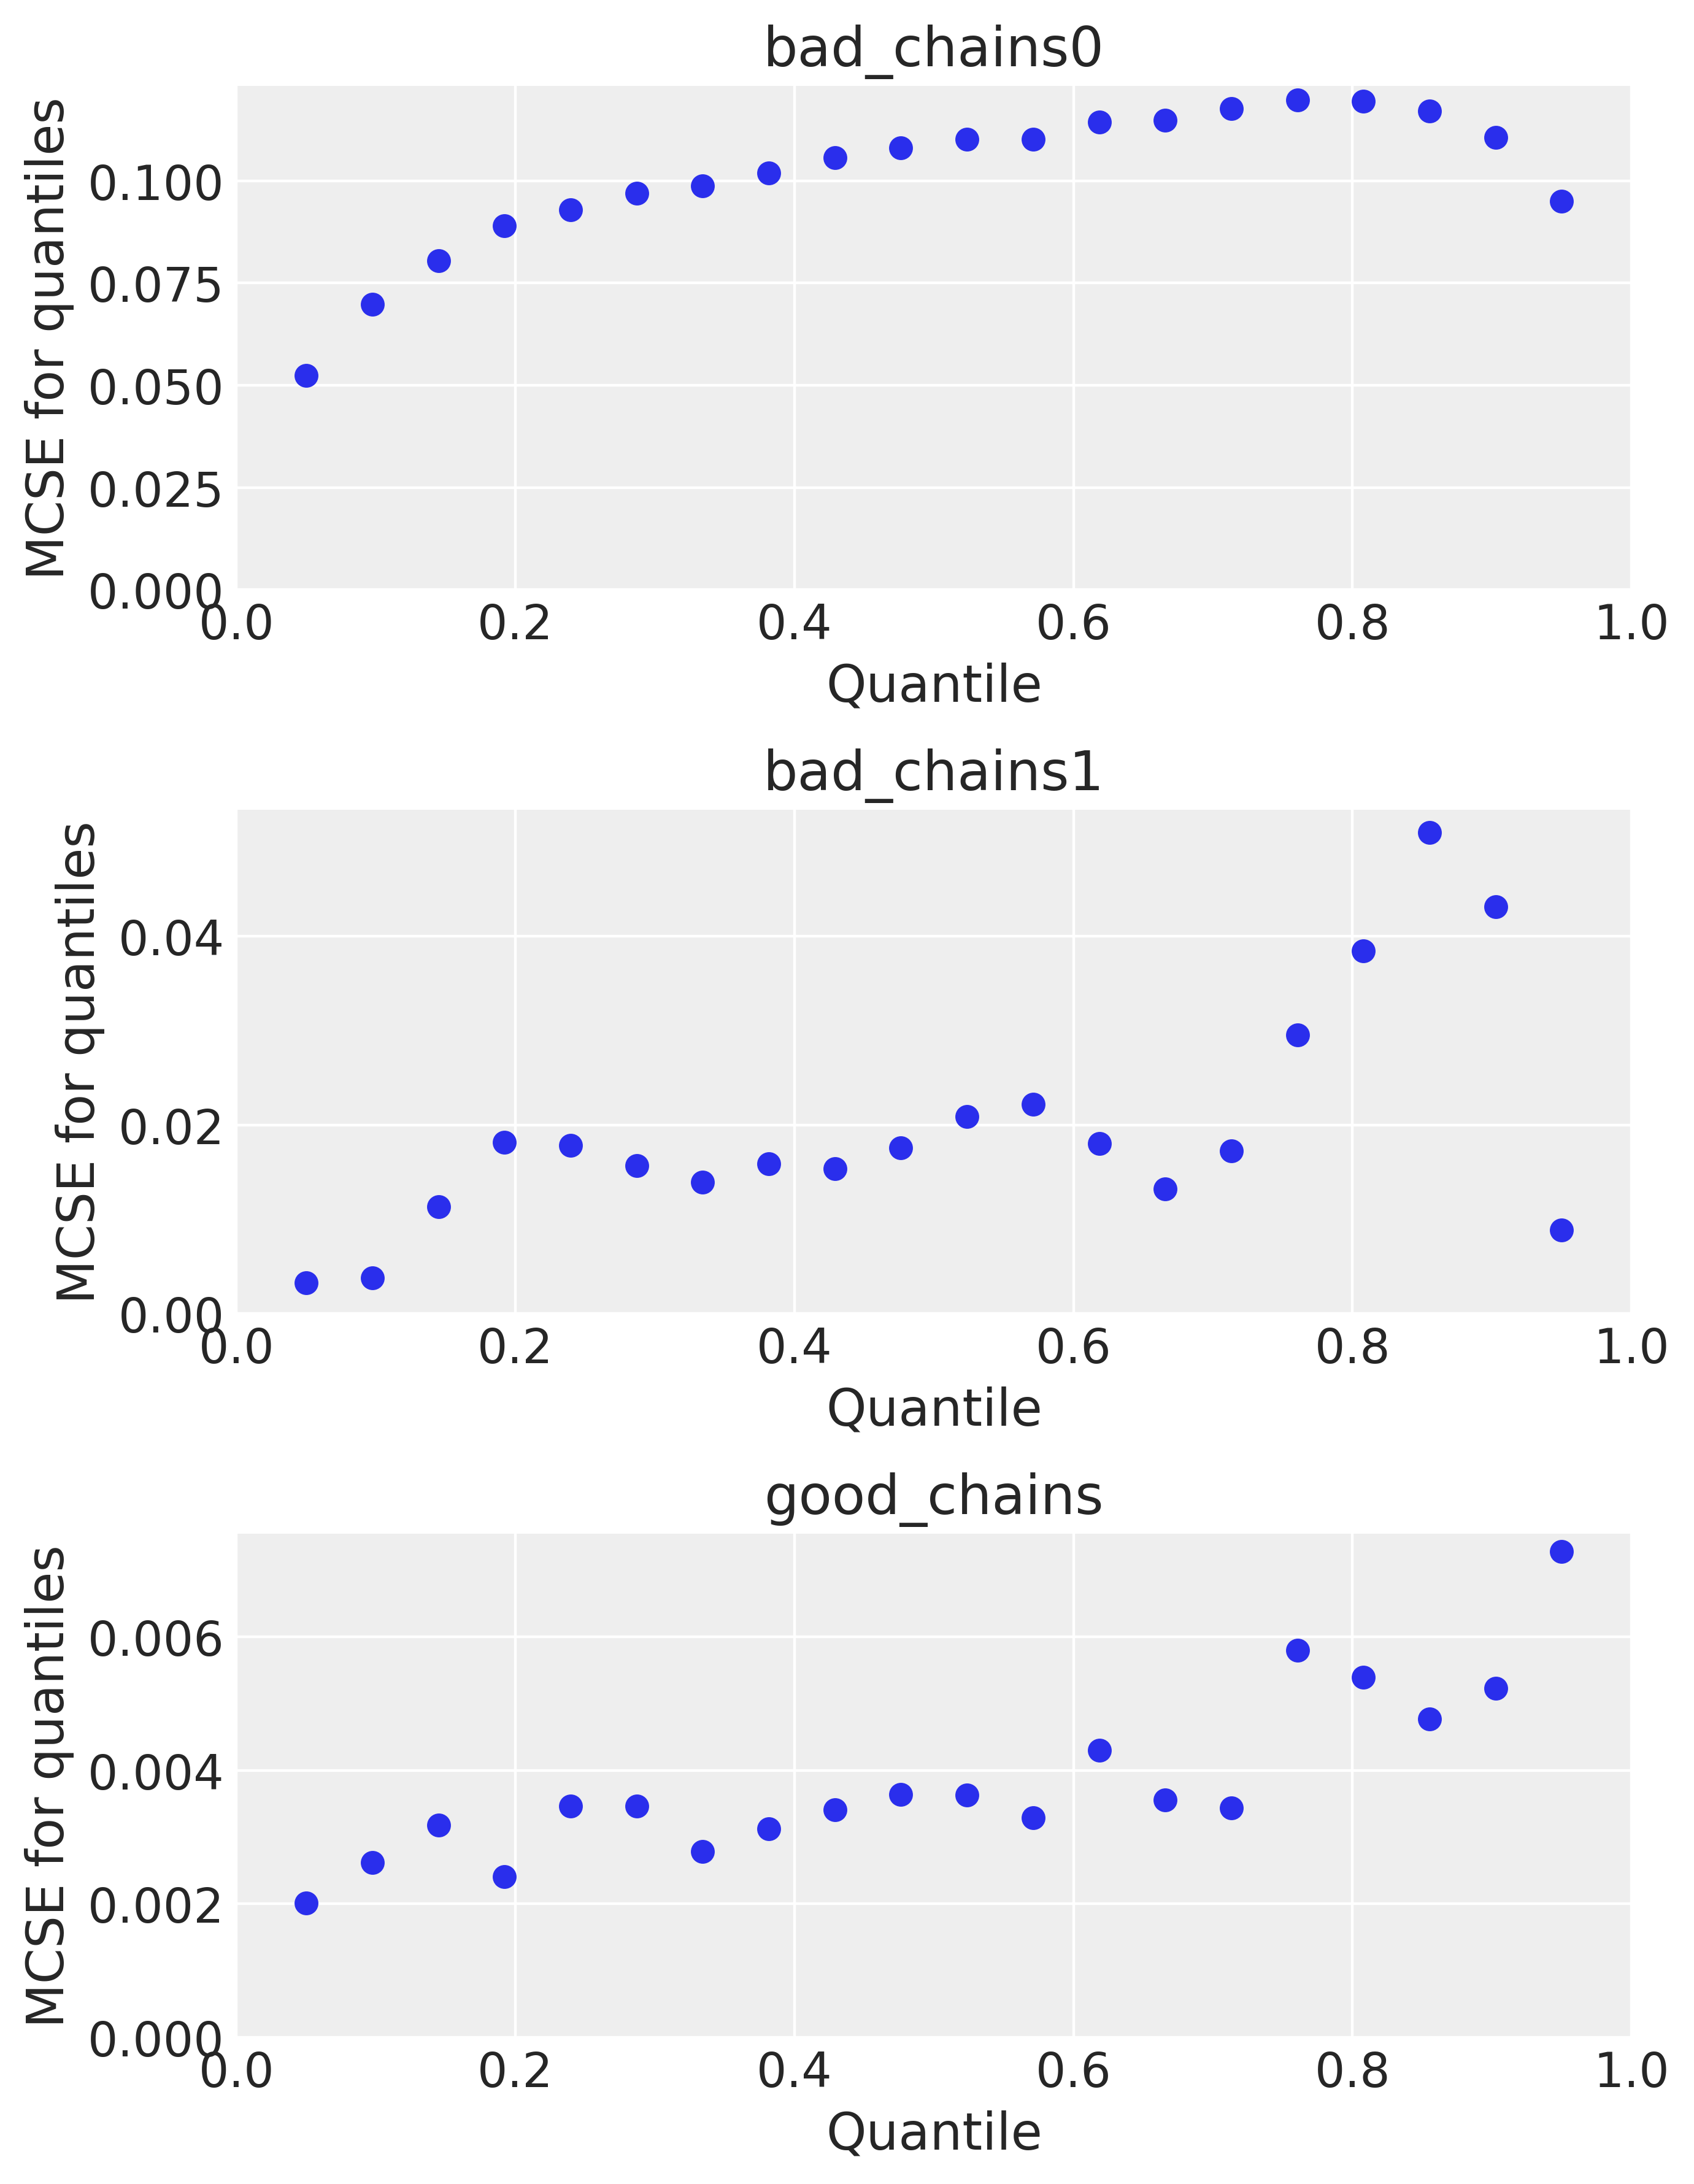

In [22]:
fig, ax = plt.subplots(3, 1, figsize=(7, 9))  
az.plot_mcse(chains, ax=ax)
plt.tight_layout()

## I Grafici di Rango Sono Piatti?

In alcune situazioni, l'interpretazione dei grafici di traccia può risultare estremamente complessa. Ad esempio, quando si raccolgono un numero molto elevato di campioni, comprimere lunghe tracce in un grafico di dimensioni standard può occultare alcuni comportamenti problematici delle catene, facendo apparire erroneamente buone le tracce. Giudicare i grafici di traccia può essere difficile anche quando le distribuzioni sono fortemente asimmetriche e/o a code pesanti. Per queste ragioni, ora si raccomanda di utilizzare i grafici di rango oltre, se non al posto, dei grafici di traccia, in modo che qualsiasi differenza nei valori campionati da ogni catena possa essere riconosciuta in un modo più affidabile (Vehtari et al., 2021). 

In statistica, il “rango” di un’osservazione è la sua posizione in un insieme di dati ordinati. Ad esempio, consideriamo il seguente insieme di dati: [5, 3, 8, 10]. Se ordiniamo questi dati in ordine crescente otterremo [3, 5, 8, 10]. In questo caso, il rango del numero 5 è 2 perché è il secondo numero nell’insieme ordinato. Allo stesso modo, il rango del numero 10 è 4 perché è il quarto numero nell’insieme ordinato.

I grafici di rango rappresentano un nuovo strumento diagnostico che si ottiene ordinando i campioni aggregati da tutte le catene, e poi presentando un istogramma dei ranghi derivanti da ogni catena separatamente. Se tutte le catene hanno come target la stessa distribuzione, allora la distribuzione dei ranghi per ogni catena dovrebbe approssimare una distribuzione uniforme. Inoltre, se i grafici dei ranghi di tutte le catene sembrano simili, ciò indica una buon mixing delle catene. Le deviazioni dall'uniformità possono indicare una vasta gamma di problemi di convergenza. Qui sotto è riportato l'esempio fornito da @martin2022bayesian:

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_95156/2441558539.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


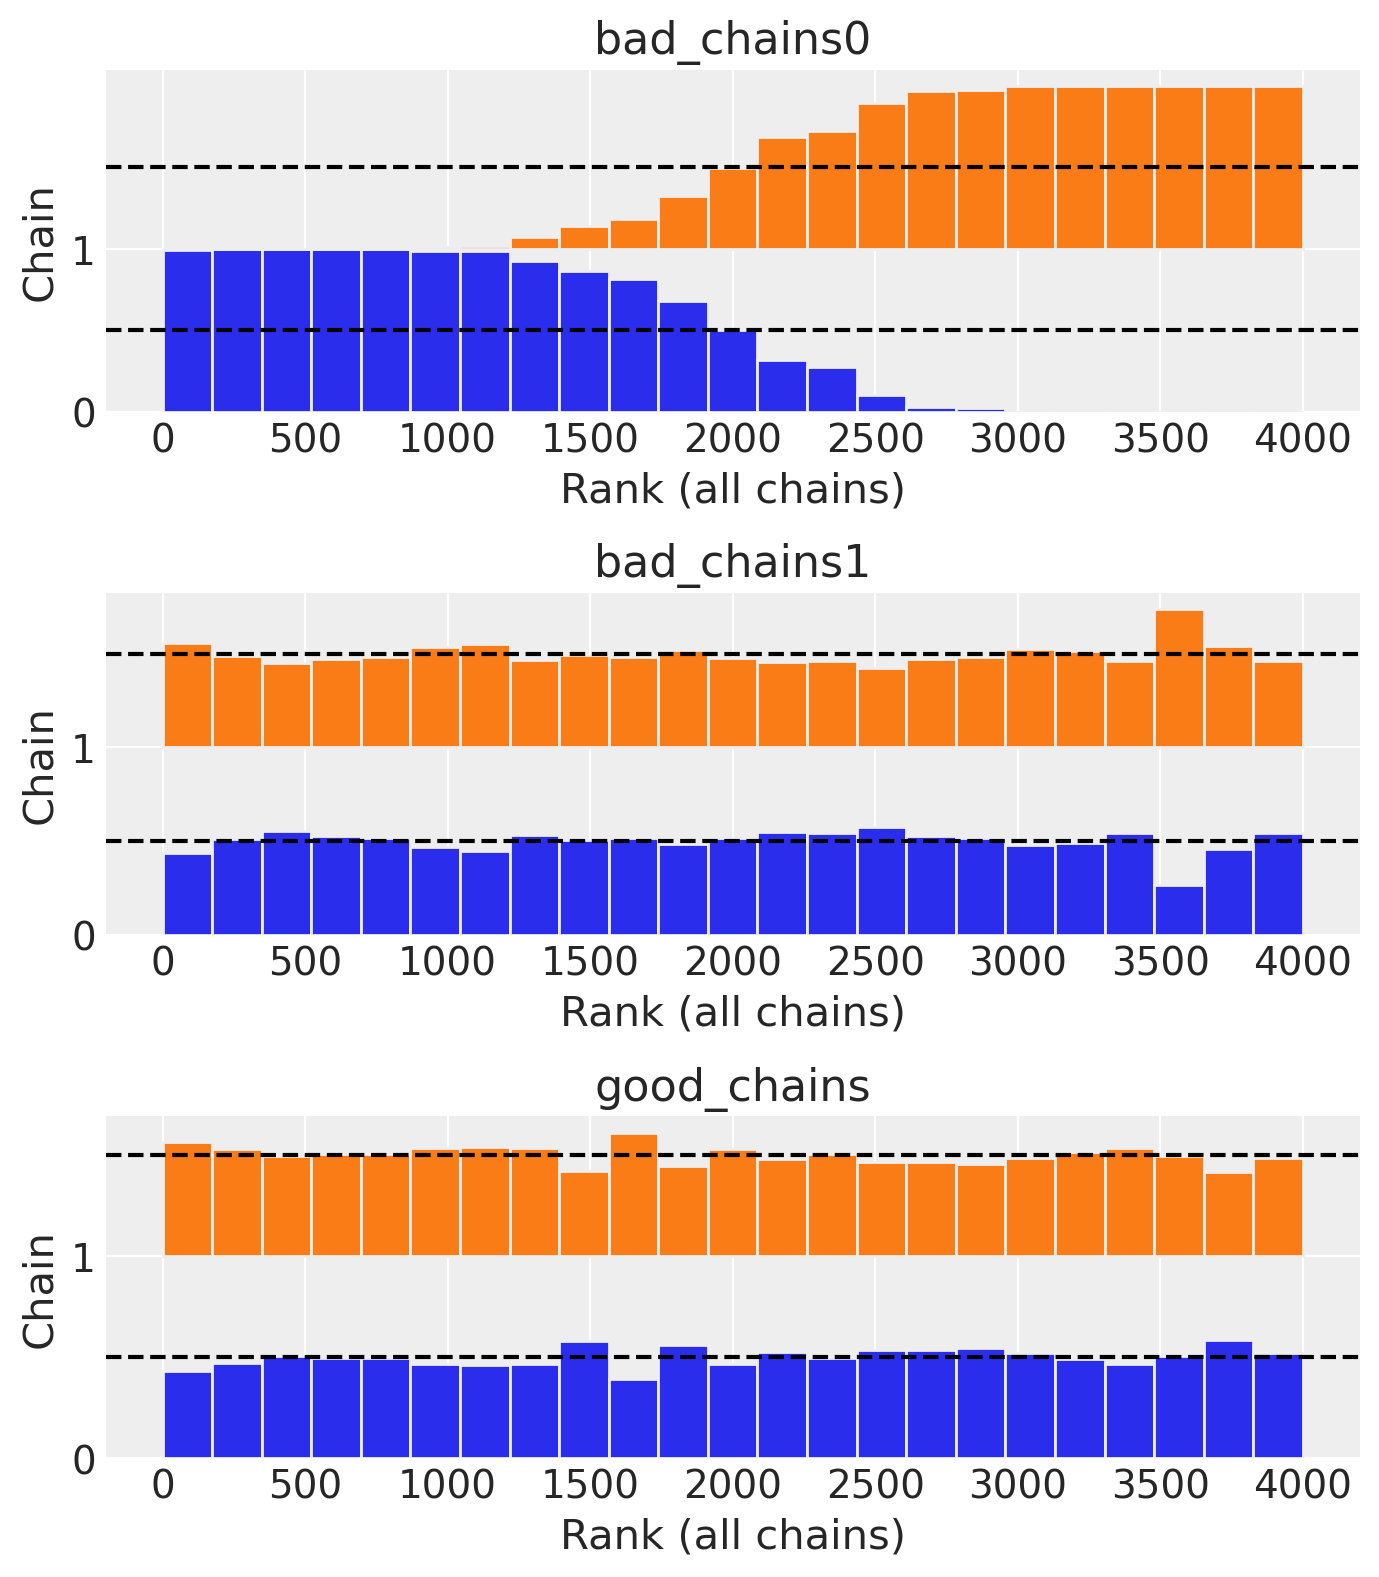

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(7, 8))  
az.plot_rank(chains, kind="bars", ax=ax)
plt.tight_layout()

Una rappresentazione alternativa (con dei segmenti verticali al posto delle barre) è la seguente:

/var/folders/s7/z86r4t9j6yx376cm120nln6w0000gn/T/ipykernel_24737/353816278.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


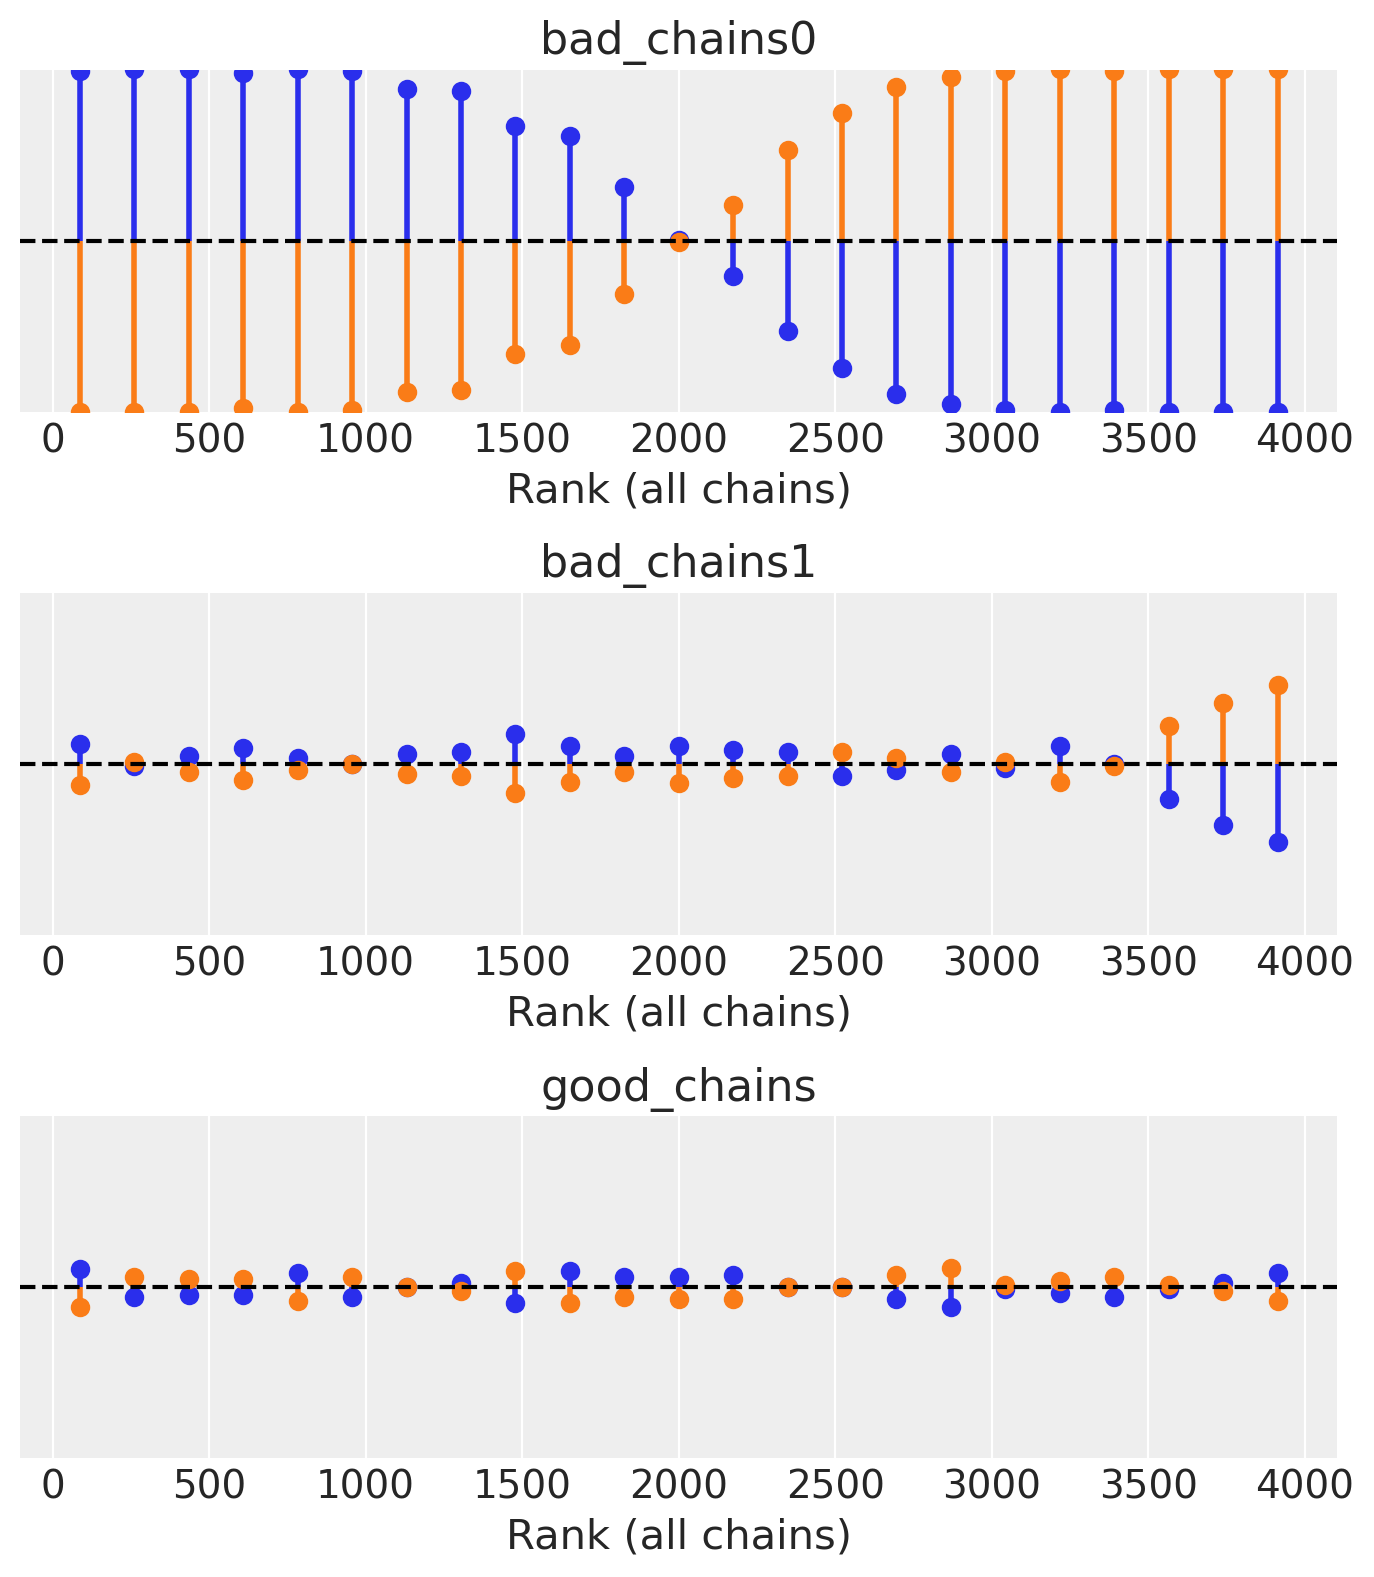

In [11]:
fig, ax = plt.subplots(3, 1, figsize=(7, 8))  
az.plot_rank(chains, kind="vlines", ax=ax)
plt.tight_layout()

## Ci Sono Transizioni Divergenti?

Quando usiamo l'algoritmo di campionamento Hamiltonian Monte Carlo (HMC), è molto importante assicurarci che non ci siano "transizioni divergenti" riportate nei risultati. Idealmente, il numero di queste transizioni dovrebbe essere zero. Una transizione divergente è come un segnale di allarme che ci avverte di possibili problemi nella fase in cui l'algoritmo esplora i vari parametri. In pratica, indica che l'algoritmo non è riuscito a esaminare correttamente alcune aree dello spazio dei parametri.

Ogni volta che notiamo una transizione divergente, dobbiamo indagare attentamente il motivo. La presenza di queste transizioni ci dice che l'algoritmo potrebbe non avere esplorato adeguatamente certe zone, mettendo a rischio l'affidabilità delle conclusioni del nostro studio. In presenza di divergenze, i campioni risultanti non possono essere considerati affidabili e, pertanto, non dovrebbero essere impiegati per la stima dei parametri, il confronto tra modelli, o qualsiasi altra forma di inferenza statistica @gelman2020bayesian.

Per capire e risolvere il problema delle transizioni divergenti, possiamo considerare diverse soluzioni:

1. **Controllo dei dati**: È utile controllare se ci sono dati anormali o estremi che potrebbero complicare il lavoro dell'algoritmo.
2. **Valutazione delle distribuzioni a priori**: Dobbiamo assicurarci che le distribuzioni a priori usate si adattino bene al modello e ai dati che stiamo analizzando. Se non sono appropriate, possono creare problemi durante l'esplorazione dello spazio dei parametri.
3. **Regolazione della dimensione del passo**: È importante controllare e, se necessario, modificare la dimensione del passo (o *step size*) dell'algoritmo HMC. Un passo troppo lungo o troppo breve può causare instabilità e favorire l'occorrenza di transizioni divergenti.

Affrontando questi problemi con attenzione, possiamo migliorare la performance dell'algoritmo HMC e ridurre il rischio di incontrare transizioni divergenti. Risolvere questi problemi è fondamentale per assicurare che l'algoritmo fornisca una rappresentazione precisa della distribuzione a posteriori e per garantire inferenze statistiche corrette.

## LA BMFI È Sufficientemente Grande?

Un altro strumento diagnostico che è stato recentemente sviluppato per il campionamento HMC/NUTS si chiama *Bayesian Fraction of Missing Information* (BFMI), calcolato in modo bayesiano. Questo indicatore si basa sull'analisi delle variazioni di energia durante ciascuna iterazione del campionamento nelle catene. Esso ci permette di capire con maggiore precisione quanto bene l'algoritmo HMC/NUTS sta funzionando a un livello più dettagliato rispetto ad altre tecniche di diagnostica.

Un valore basso di BFMI in una catena specifica indica che l'algoritmo non sta esplorando efficacemente la distribuzione dei dati che stiamo analizzando, il che può portare a risultati distorti o fuorvianti. È generalmente accettato che il valore di BFMI debba essere almeno 0.2 per ogni catena. Se in una o più catene il valore scende al di sotto di 0.2, si considera che i risultati ottenuti non siano affidabili per fare inferenze corrette, poiché le stime prodotte potrebbero essere distorte [@betancourt2016diagnosing].

## La Leave-One-Out Cross-Validation Fornisce Evidenze di Buon Adattamento?

La Leave-One-Out Cross-Validation (LOO) rappresenta un metodo ampiamente impiegato nell'ambito dell'analisi bayesiana per valutare quanto adeguatamente un modello statistico si adatta ai dati osservati. Immaginiamo di avere una serie di foto e di voler valutare quanto bene un software riesce a riconoscere le persone in queste foto. La LOO ci aiuta a testare il software in un modo accurato.

Il processo è semplice: prendiamo tutte le foto tranne una, e usiamo queste per insegnare al software come riconoscere le persone. Poi, usiamo la foto che abbiamo messo da parte per vedere se il software riesce a riconoscere la persona in quella foto. Ripetiamo questo processo per ogni singola foto, una alla volta. Ogni volta, il software apprende da tutte le foto tranne una, e quella esclusa serve per testarlo.

Questo metodo è molto efficace perché assicura che il software non impari solo a riconoscere le persone nelle foto specifiche che ha già visto (questo si chiama "overfitting", ovvero sovraadattamento), ma che sia davvero capace di riconoscere persone anche in foto nuove che non ha mai analizzato. Inoltre, evita il problema opposto, chiamato "underfitting", dove il software non impara abbastanza dai dati e quindi non riesce a fare buone previsioni.

Nel contesto dell'analisi bayesiana, dove si utilizzano modelli statistici complessi, la LOO è spesso accompagnata da calcoli come il logaritmo della verosimiglianza, che aiutano a quantificare quanto bene il modello riesce a prevedere i dati esclusi. I risultati di questi calcoli possono essere usati per calcolare un indice chiamato LOOIC (Leave-One-Out Information Criterion), che permette di confrontare diversi modelli per scegliere quello che si adatta meglio ai dati.

In conclusione, la LOO è uno strumento molto utile per valutare in modo imparziale e preciso quanto bene un modello statistico possa prevedere nuovi dati, garantendo che le nostre previsioni siano il più accurate possibile.

## Il Parametro $k$

Il parametro $k$, noto anche come parametro di coda di Pareto, riveste un ruolo importante nell'ambito del campionamento MCMC. È utilizzato per valutare l'efficienza e la convergenza delle catene di campionamento, nonché per misurare la qualità del processo di campionamento di importanza, come nel caso del Pareto Smoothed Importance Sampling (PSIS).

Immaginiamo di essere a una festa dove stai cercando di scoprire quale gusto di gelato è il preferito tra gli invitati. Invece di chiedere a tutti, decidiamo di assaggiare solo alcuni gelati per avere un'idea generale. Questo processo di selezionare solo alcuni gelati per fare un'assunzione sul gusto preferito è simile a quello che avviene nel campionamento per l'Importance Sampling: scegliamo solo alcuni punti (o "campioni") da un insieme molto grande per fare delle stime su tutta la popolazione.

Nel Pareto Smoothed Importance Sampling (PSIS), dopo aver scelto i campioni, cerchiamo di "lisciare" le nostre stime per renderle più precise e meno variabili. Pensalo come se stessi cercando di bilanciare le risposte per non dare troppo peso a poche opinioni estreme.

Il parametro $k$ ci dice quanto siamo vicini a raggiungere questo obiettivo di bilanciamento. Se $k$ è vicino a 0, significa che abbiamo fatto un buon lavoro: le nostre stime sono affidabili e non troppo dipendenti da pochi campioni estremi. Se, invece, $k$ è più alto, specialmente sopra 0.7, ci indica che ci sono problemi: forse abbiamo dato troppo peso a poche opinioni estreme, o non abbiamo un buon mix di opinioni per fare una stima affidabile. In pratica, un $k$ alto è come un campanello d’allarme che ci dice che dobbiamo essere cauti con le nostre conclusioni e, possibilmente, raccogliere più dati o ripensare come li stiamo campionando.

In sostanza, il parametro $k$ è uno strumento per aiutarci a capire quanto possiamo fidarci delle nostre stime basate su un campione limitato di dati. Un valore basso è buono, indicando che le stime sono solide e ben equilibrate, mentre un valore alto suggerisce che potremmo avere dei problemi e che dovremmo esaminare più attentamente i dati che abbiamo raccolto.

Per calcolare il parametro $\hat{\kappa}$, è possibile fare uso di ArviZ, uno strumento appositamente progettato per le analisi bayesiane avanzate.

## Informazioni sull'Ambiente di Sviluppo {.unnumbered}

In [12]:
%load_ext watermark
%watermark -n -u -v -iv -w -m

Last updated: Mon Jun 10 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 23.4.0
Machine     : arm64
Processor   : arm
CPU cores   : 8
Architecture: 64bit

matplotlib: 3.8.4
logging   : 0.5.1.2
cmdstanpy : 1.2.3
scipy     : 1.13.1
arviz     : 0.18.0
numpy     : 1.26.4
pandas    : 2.2.2

Watermark: 2.4.3

